# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [5]:
labels = pd.read_csv('train.csv')

In [6]:
print('Размер выборки:', labels.shape)

Размер выборки: (19906, 2)


KeyError: 'real_age'

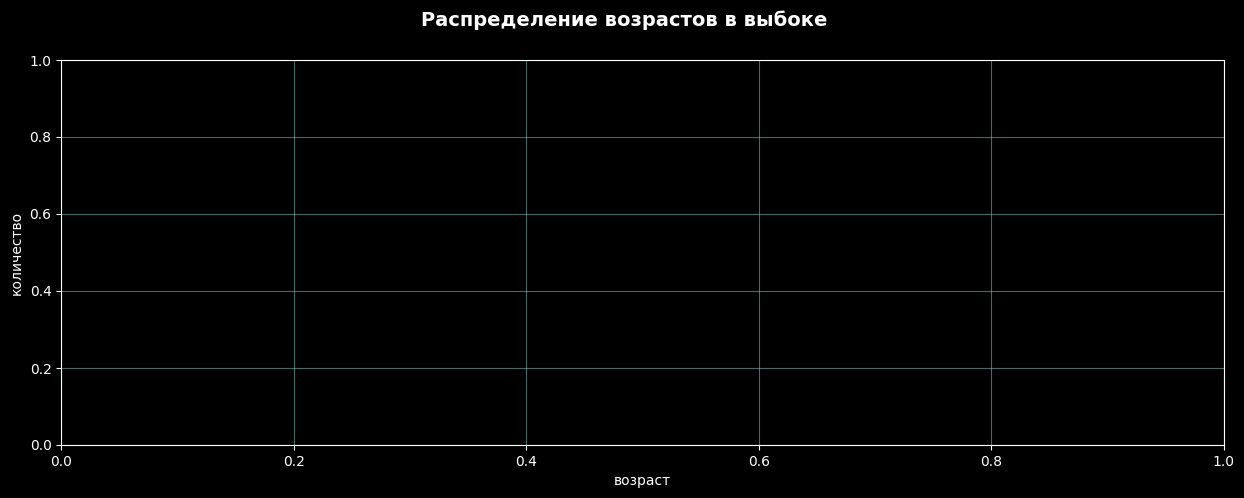

In [7]:
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot()
fig.subplots_adjust()
fig.suptitle('Распределение возрастов в выбоке', fontsize=14, fontweight='bold')
ax.set_xlabel('возраст')
ax.set_ylabel('количество')
plt.grid(color=(0.55, 0.83, 0.78), alpha=0.5)
plt.hist(labels['real_age'],color=(0.55, 0.83, 0.78), alpha=0.5, edgecolor = 'black', bins = 100)
plt.show();

In [19]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [13]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

features, target = next(gen_flow)

Found 7591 validated image filenames.


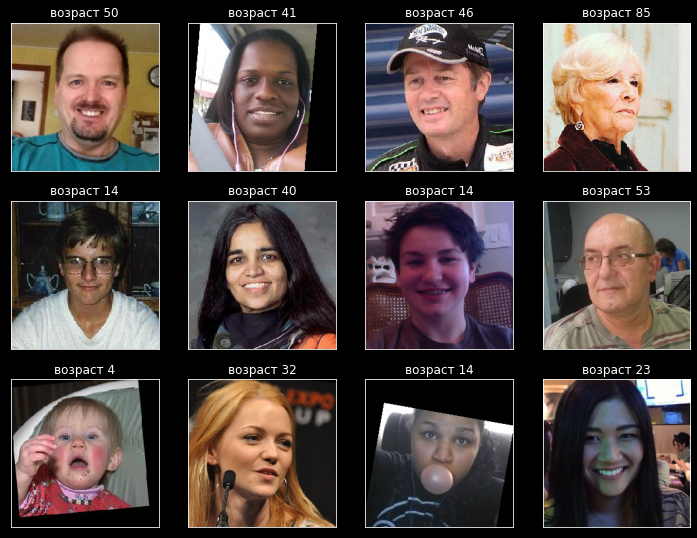

In [18]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title('возраст ' + str(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод по анализу данных

- загружен датасет из 7591 фотографии лиц с размеченым возрастом. Этого количества достаточно для построения модели
- большинство лиц в датасете принадлежат людям с возрастом около 30 лет (29 по медиане и около 31 среднее)
- минимальный и максимальный возроста 1 год и 100 лет
- лица на фото отцентрованы и приведены к похожим размерам, глаза находятся по центры по горизонтали и в верхней трети по вертикали
- по обрезанным и повернутым краям видно что фотографии предобрабатывали
- из аугментации подойдёт отражение по горизонтали так как лица симетричны по горизонтали и отраженное фото останется естественным
- не подойдут: отражение по вертикали так как это перевернёт лицо и сделает фото не естественным; сдвиги и повороты так как сильно будут выбивать фото из формата к которому их подогнали и добавят ещё больше чёрных областей на тех фото где они уже есть

## Обучение модели

```python
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=1337)
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=1337)
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False) 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        shuffle=True,
        verbose=2)
    return model
```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 67s - loss: 202.4002 - mae: 10.3688 - val_loss: 596.0047 - val_mae: 19.3551
Epoch 2/10
356/356 - 41s - loss: 81.4495 - mae: 6.8588 - val_loss: 119.9440 - val_mae: 8.2538
Epoch 3/10
356/356 - 40s - loss: 56.9223 - mae: 5.7992 - val_loss: 79.1920 - val_mae: 6.6533
Epoch 4/10
356/356 - 40s - loss: 41.4482 - mae: 4.9510 - val_loss: 74.9134 - val_mae: 6.4953
Epoch 5/10
356/356 - 41s - loss: 30.9349 - mae: 4.2629 - val_loss: 76.4628 - val_mae: 6.3709
Epoch 6/10
356/356 - 41s - loss: 26.1020 - mae: 3.9245 - val_loss: 99.7140 - val_mae: 7.6700
Epoch 7/10
356/356 - 40s - loss: 20.6927 - mae: 3.4737 - val_loss: 69.3524 - val_mae: 6.1377
Epoch 8/10
356/356 - 41s - loss: 17.0390 - mae: 3.1579 - val_loss: 69.8058 - val_mae: 6.3227
Epoch 9/10
356/356 - 42s - loss: 15.3958 - mae: 2.9921 - val_loss: 63.0233 - val_mae: 5.9313
Epoch 10/10
356/356 - 46s - loss: 13.1051 - mae: 2.7770 - val_loss: 64.6206 - val_mae: 6.0181

119/119 - 11s - loss: 64.0340 - mae: 5.9984
Test MAE: 5.9984
```

## Анализ обученной модели

Для обущения модели произведена аугментация с отражением по горизонтали, яркость приведена к диапозону [0,1]
За основу взят бэкбон предобученной модели ResNet50, заморозка не производилась так как фотографий в выборке достаточно.
размер батча 16 фотографий, оптимизатор Adam с шагом 0.0001, функция потерь MSE.

Исходя из того что на тренировочной выборке метрики лучше чем на тестовой (например на 10 эпохе МАЕ составляет 2.7770 на тренировочной и 6.0181 на тестовой), можно сделать вывод что модель переобучилась, но это нормально для таких моделей

Модель достигла требуемого значения MAE менее 8 за 10 эпох. но достаточного качества можно было бы достигнуть уже за 3 эпохи, тем самым сделав модель быстрее.

- Итоговоая метрика MAE составила 5.9984 